# Explanation of `lcparam_full_long.txt`

The file `lcparam_full_long.txt` contains a table of key parameters recovered from light-curve fits for the full Pantheon sample of Type Ia supernovae. The Pantheon sample is a compilation of supernova observations used to study cosmology, particularly to understand the expansion of the universe.

## Columns in the File

1. **name**: The identifier for the supernova.
2. **zcmb**: The redshift of the supernova in the Cosmic Microwave Background (CMB) frame.
3. **zhel**: The heliocentric redshift of the supernova.
4. **dz**: The uncertainty in the redshift.
5. **mb**: The B-band peak magnitude of the supernova.
6. **dmb**: The uncertainty in the B-band peak magnitude.
7. **x1**: The stretch parameter (describes the shape of the light curve).
8. **dx1**: The uncertainty in the stretch parameter.
9. **color**: The color parameter (describes the color of the supernova).
10. **dcolor**: The uncertainty in the color parameter.
11. **3rdvar**: A third variable related to the supernova (often used for additional corrections).
12. **d3rdvar**: The uncertainty in the third variable.
13. **cov_m_s**: Covariance between the B-band magnitude and the stretch parameter.
14. **cov_m_c**: Covariance between the B-band magnitude and the color parameter.
15. **cov_s_c**: Covariance between the stretch parameter and the color parameter.
16. **set**: The data set the supernova belongs to.
17. **ra**: The right ascension of the supernova.
18. **dec**: The declination of the supernova.
19. **biascor**: The bias correction applied to the supernova data.

## Use in Cosmology

These parameters are crucial for determining the distances to the supernovae and for constructing the Hubble diagram, which is used to study the expansion history of the universe. The redshift provides a measure of how much the universe has expanded since the light left the supernova, while the B-band peak magnitude (after corrections) gives the luminosity distance. The stretch and color parameters are used to correct the observed magnitudes for various effects. Covariances provide information on how the uncertainties in these parameters are related.


In [21]:
import pandas as pd
import numpy as np

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()  # Read and strip the first line
    header = header_line.lstrip('#').strip()  # Remove leading '#' and any extra whitespace

# Remove the last word from the header
header_words = header.split()  # Split into words
header_words.pop()  # Remove the last word
header = ' '.join(header_words)  # Join the remaining words back into a string

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)  # Skip the first line and don't set headers

# Set the header for the DataFrame
data.columns = header.split()  # Set columns using the stripped header

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Use the observed data as a placeholder for theoretical values
# In a real scenario, you would use your model's predictions here
mu = np.mean(d)

# Compute the covariance matrix (assuming it is diagonal with dmb as standard deviations)
Sigma = np.diag(dmb**2)

# Compute the inverse of the covariance matrix
Sigma_inv = np.linalg.inv(Sigma)

# Compute the residuals
Delta = d - mu

# Vector of ones
ones = np.ones_like(d)

# Compute the terms
term1 = Delta.T @ Sigma_inv @ Delta
term2 = (ones.T @ Sigma_inv @ Delta)**2 / (ones.T @ Sigma_inv @ ones)

# Compute the log-likelihood
lnLm = -0.5 * (term1 - term2)

print("Log Likelihood:", lnLm)


Log Likelihood: -165817.77826682583


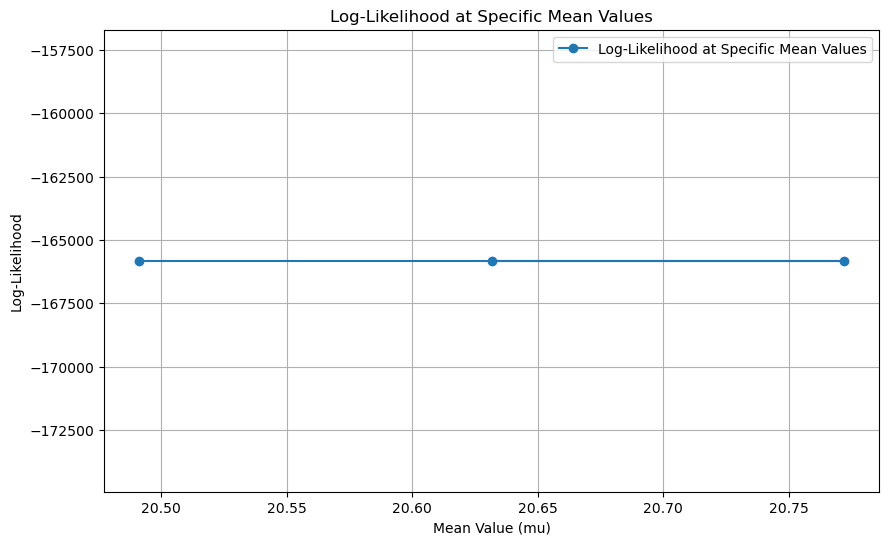

Log Likelihood Values: [-165817.77826682583, -165817.77826682577, -165817.7782668258]


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()  # Read and strip the first line
    header = header_line.lstrip('#').strip()  # Remove leading '#' and any extra whitespace

# Remove the last word from the header
header_words = header.split()  # Split into words
header_words.pop()  # Remove the last word
header = ' '.join(header_words)  # Join the remaining words back into a string

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)  # Skip the first line and don't set headers

# Set the header for the DataFrame
data.columns = header.split()  # Set columns using the stripped header

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Define the log-likelihood function
def log_likelihood(d, mu, Sigma):
    """
    Compute the log-likelihood for a given set of parameters and data.

    Parameters:
    d (np.array): Observed data.
    mu (np.array): Mean values (theoretical predictions).
    Sigma (np.array): Covariance matrix.

    Returns:
    float: Log-likelihood value.
    """
    # Compute the inverse of the covariance matrix
    Sigma_inv = np.linalg.inv(Sigma)

    # Compute the residuals
    Delta = d - mu

    # Vector of ones
    ones = np.ones_like(d)

    # Compute the terms
    term1 = Delta.T @ Sigma_inv @ Delta
    term2 = (ones.T @ Sigma_inv @ Delta)**2 / (ones.T @ Sigma_inv @ ones)

    # Compute the log-likelihood
    lnLm = -0.5 * (term1 - term2)

    return lnLm

# Compute the covariance matrix (assuming it is diagonal with dmb as standard deviations)
Sigma = np.diag(dmb**2)

# Calculate specific mean values to test
mean_d = np.mean(d)
mean_dmb = np.mean(dmb)

# Define specific mu values based on the mean of d and dmb
mu_values = [mean_d, mean_d + mean_dmb, mean_d - mean_dmb]

# Compute log-likelihood for each value of mu
log_likelihood_values = [log_likelihood(d, np.full_like(d, mu), Sigma) for mu in mu_values]

# Plot the log-likelihood values
plt.figure(figsize=(10, 6))
plt.plot(mu_values, log_likelihood_values, 'o-', label='Log-Likelihood at Specific Mean Values')
plt.xlabel('Mean Value (mu)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood at Specific Mean Values')
plt.legend()
plt.grid(True)
plt.show()

print("Log Likelihood Values:", log_likelihood_values)

In [23]:
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Log-likelihood function
def log_likelihood(params, d, Sigma_inv):
    mu = params[0]
    Delta = d - mu
    ones = np.ones_like(d)
    
    term1 = Delta.T @ Sigma_inv @ Delta
    term2 = (ones.T @ Sigma_inv @ Delta)**2 / (ones.T @ Sigma_inv @ ones)
    
    return -0.5 * (term1 - term2)

# Log-prior function
def log_prior(params):
    mu = params[0]
    if 0 < mu < 30:
        return 0.0
    return -np.inf

# Log-posterior function
def log_posterior(params, d, Sigma_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, d, Sigma_inv)

# Initial guess for the parameter
initial = np.array([np.mean(d)])

# Number of dimensions
ndim = len(initial)

# Number of walkers
nwalkers = 50

# Initial positions of the walkers
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(d, Sigma_inv))

# Run the MCMC sampler
nsteps = 1000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Plot the results
fig = corner.corner(samples, labels=["mu"], truths=[np.mean(d)])
plt.show()

# Print the mean and standard deviation of the posterior distribution
mu_mcmc = np.mean(samples)
mu_std = np.std(samples)
print(f"Mean of mu: {mu_mcmc}")
print(f"Standard deviation of mu: {mu_std}")


  1%|          | 12/1000 [00:00<00:33, 29.30it/s]Traceback (most recent call last):
  File "/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/zj/ynn451w51tl8mfxzn0g716qr0000gn/T/ipykernel_14436/948314345.py", line 55, in log_posterior
    return lp + log_likelihood(params, d, Sigma_inv)
  File "/var/folders/zj/ynn451w51tl8mfxzn0g716qr0000gn/T/ipykernel_14436/948314345.py", line 39, in log_likelihood
    term2 = (ones.T @ Sigma_inv @ Delta)**2 / (ones.T @ Sigma_inv @ ones)
KeyboardInterrupt
  1%|          | 12/1000 [00:00<00:35, 27.96it/s]


emcee: Exception while calling your likelihood function:
  params: [20.63909694]
  args: (array([22.93445, 22.8802 , 24.0377 , ..., 18.72405, 22.6586 , 22.8011 ]), array([[62.93819737,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 72.24638764,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 23.65667913, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 73.2390271 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        41.75790334,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 46.12001003]]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

     name     zcmb     zhel   dz        mb      dmb  x1  dx1  color  dcolor  \
0  03D1au  0.50309  0.50309  0.0  22.93445  0.12605   0    0      0       0   
1  03D1ax  0.49480  0.49480  0.0  22.88020  0.11765   0    0      0       0   
2  03D1co  0.67767  0.67767  0.0  24.03770  0.20560   0    0      0       0   
3  03D1ew  0.86650  0.86650  0.0  24.34685  0.17385   0    0      0       0   
4  03D1fq  0.79857  0.79857  0.0  24.36050  0.17435   0    0      0       0   

   3rdvar  d3rdvar  cov_m_s  cov_m_c  cov_s_c  set  ra  dec  
0       0        0        0        0        0    0   0    0  
1       0        0        0        0        0    0   0    0  
2       0        0        0        0        0    0   0    0  
3       0        0        0        0        0    0   0    0  
4       0        0        0        0        0    0   0    0  
Covariance Matrix (Sigma):
[[0.0158886  0.         0.         ... 0.         0.         0.        ]
 [0.         0.01384152 0.         ... 0.         0. 

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:00<00:00, 2283.77it/s]


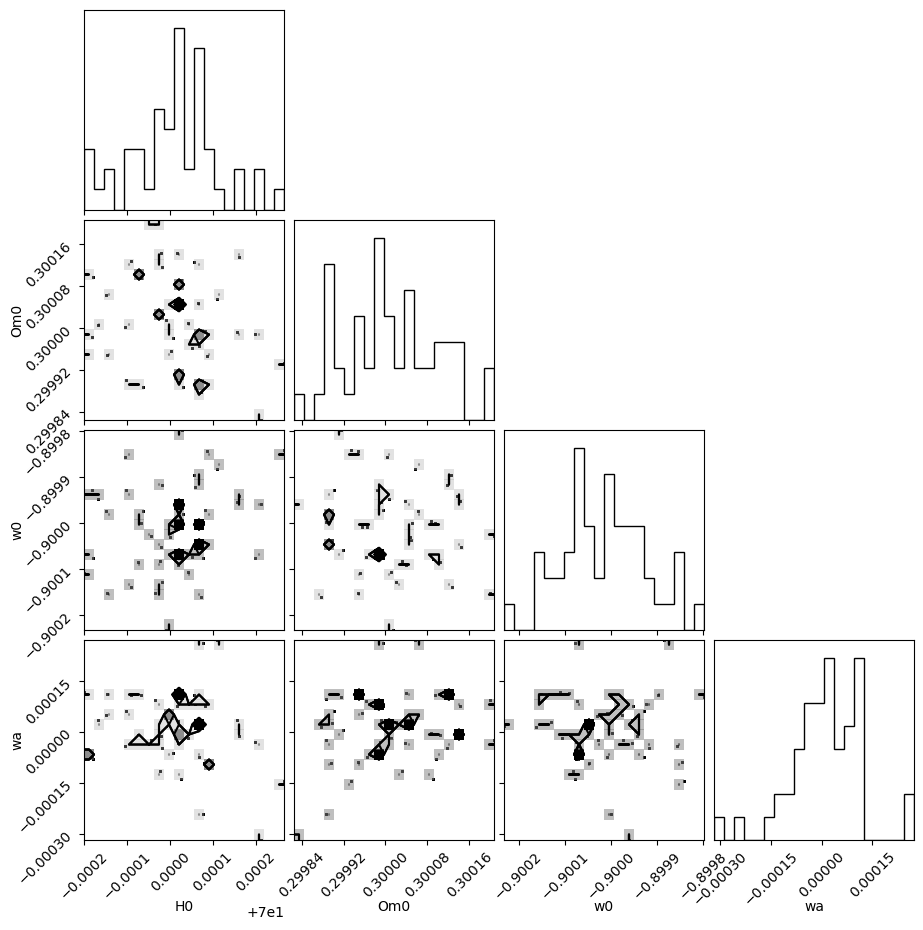

'\nnwalkers = 50\nndim = 4\ninitial = [70, 0.3, -1, 0]  # Initial guess for H0, Om0, w0, wa\npos = initial + 1e-4 * np.random.randn(nwalkers, ndim)\n\nsampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))\nsampler.run_mcmc(pos, 5000, progress=True)\n\n# Get the MCMC samples\nsamples = sampler.get_chain(discard=100, thin=15, flat=True)\n\n# Plot the results\nfig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"], truths=[70, 0.3, -1, 0])\n'

In [ ]:
import pandas as pd
import numpy as np
import camb
import emcee
import corner

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Check the data and covariance matrix
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Define the cosmological model
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    mu = get_mu(z, H0, Om0, w0, wa)
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

# Define the log-posterior function
def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Modify the prior range for w0 to exclude values close to -1
def log_prior(params):
    H0, Om0, w0, wa = params
    if 0 < H0 < 100 and 0 < Om0 < 1 and -2 < w0 < -0.99 and -2 < wa < 2:
        return 0.0
    return -np.inf

# Initialize the MCMC sampler
# keeping in mind that i have to exclude values of w0 close to -1
initial = np.array([70, 0.3, -0.9, 0.0])
ndim = len(initial)
nwalkers = 50
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 1000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()

'''
nwalkers = 50
ndim = 4
initial = [70, 0.3, -1, 0]  # Initial guess for H0, Om0, w0, wa
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))
sampler.run_mcmc(pos, 5000, progress=True)

# Get the MCMC samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"], truths=[70, 0.3, -1, 0])
'''


Using CAMB 1.5.4 installed at /Users/marigalla/AstroCosmoComputational/Students/MariaLuisaGallavotti/CAMB/camb
     name     zcmb     zhel   dz        mb      dmb  x1  dx1  color  dcolor  \
0  03D1au  0.50309  0.50309  0.0  22.93445  0.12605   0    0      0       0   
1  03D1ax  0.49480  0.49480  0.0  22.88020  0.11765   0    0      0       0   
2  03D1co  0.67767  0.67767  0.0  24.03770  0.20560   0    0      0       0   
3  03D1ew  0.86650  0.86650  0.0  24.34685  0.17385   0    0      0       0   
4  03D1fq  0.79857  0.79857  0.0  24.36050  0.17435   0    0      0       0   

   3rdvar  d3rdvar  cov_m_s  cov_m_c  cov_s_c  set  ra  dec  
0       0        0        0        0        0    0   0    0  
1       0        0        0        0        0    0   0    0  
2       0        0        0        0        0    0   0    0  
3       0        0        0        0        0    0   0    0  
4       0        0        0        0        0    0   0    0  
Covariance Matrix (Sigma):
[[0.0158886  0.

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 20%|█▉        | 195/1000 [00:00<00:00, 1947.00it/s]

Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w cros

 58%|█████▊    | 579/1000 [00:00<00:00, 1648.20it/s]

Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w cros

 96%|█████████▌| 959/1000 [00:00<00:00, 1801.56it/s]

Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w cros

100%|██████████| 1000/1000 [00:00<00:00, 1677.58it/s]

Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w crossing -1
Error in get_mu: fluid dark energy model does not support w cros

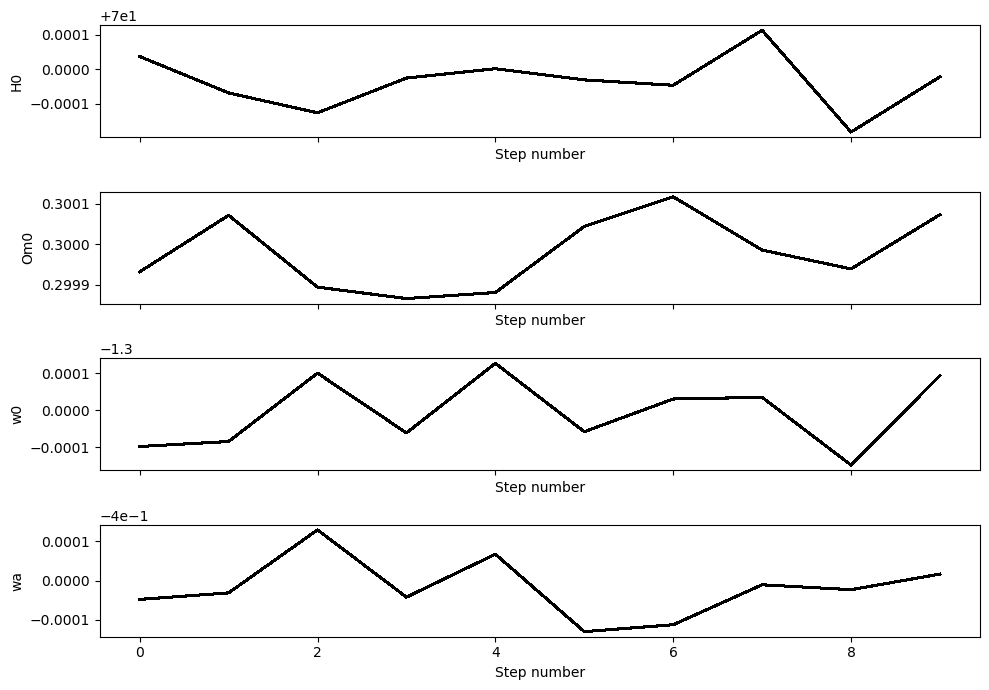

Autocorrelation times: [0.34290667]


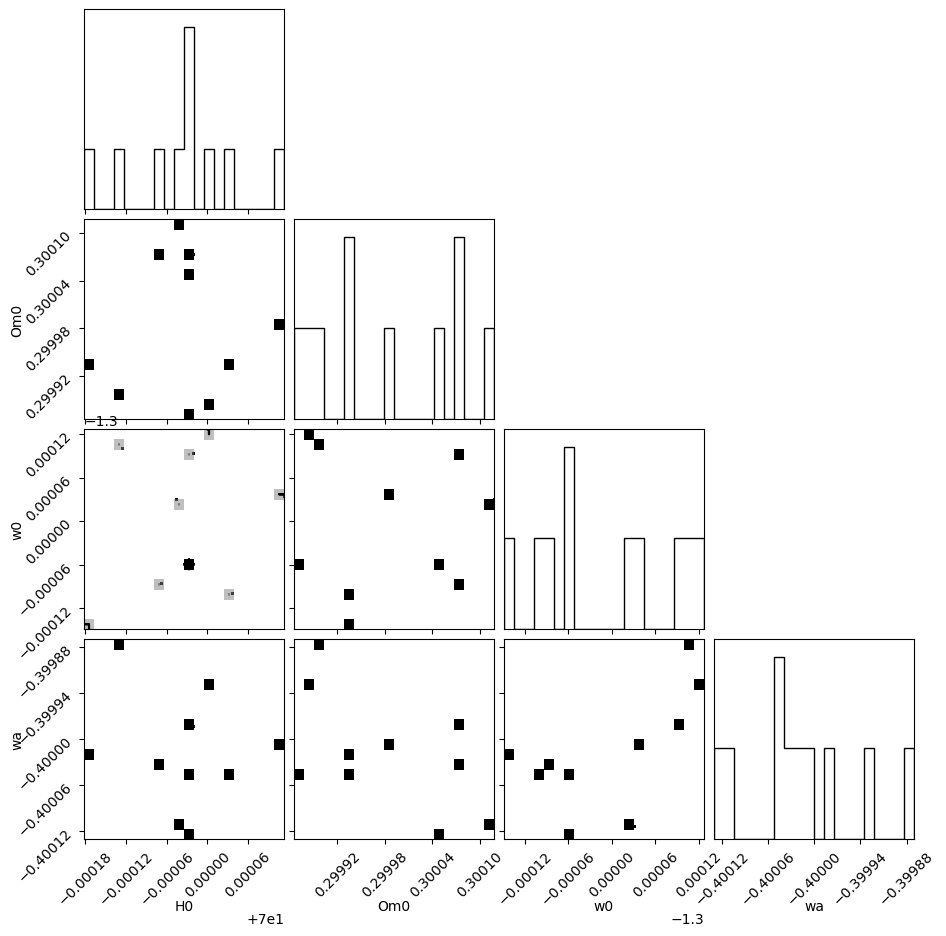

In [55]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Check the data and covariance matrix
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Define the cosmological model
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

# Define the log-posterior function
def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

'''
# Modify the prior range for w0 to exclude values close to -1
def log_prior(params):
    H0, Om0, w0, wa = params
    if 0 < H0 < 100 and 0 < Om0 < 1 and -2 < w0 < -0.5 and -2 < wa < 2:
        return 0.0
    print(f"Invalid prior for params: {params}")
    return -np.inf
'''

def log_prior(params):
    H0, Om0, w0, wa = params
    
    # Basic parameter bounds
    if not (60 < H0 < 80):
        print(f"Invalid H0: {H0}")
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        print(f"Invalid Om0: {Om0}")
        return -np.inf
    if not (-2 < w0 < -1.1):
        print(f"Invalid w0: {w0}")
        return -np.inf
    if not (-1 < wa < 0):
        print(f"Invalid wa: {wa}")
        return -np.inf

    # Constraint to avoid crossing w = -1 (relaxed)
    if w0 + wa > -1:
        print(f"Invalid w0 + wa (>-0.9): {w0 + wa}")
        return -np.inf
    
    # Constraint to ensure w_0 + w_a ≤ 0 at high redshift (relaxed)
    if w0 + wa > 0.5:
        print(f"Invalid w0 + wa (>0.5): {w0 + wa}")
        return -np.inf

    return 0.0



# Example initialization within reasonable bounds
def initialize_walkers(nwalkers, ndim):
    # Ensure that the initial positions are within the valid bounds
    initial = [70, 0.3, -1.3, -0.4]  # Example initial values
    pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
    return pos


ndim = 4  # Number of dimensions
nwalkers = 10  # Smaller number of walkers for debugging
nsteps = 1000  # Fewer steps for debugging

# Initialize the MCMC sampler with debug settings
pos = initialize_walkers(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args=(data, Sigma_inv))
sampler.run_mcmc(pos, nsteps, progress=True)

# Check results
samples = sampler.get_chain(flat=True)
print("Sample shape:", samples.shape)


'''
# Initialize the MCMC sampler
initial = np.array([70, 0.3, -0.9, 0.0])
ndim = len(initial)
nwalkers = 10
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Check initial likelihoods
print("Initial log-posterior values:")
for i in range(nwalkers):
    print(f"Walker {i}: {log_posterior(pos[i], data, Sigma_inv)}")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 5000  # Increase the number of steps
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
'''

# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Convergence diagnostics
from emcee import autocorr

# Compute the autocorrelation time for each parameter
tau = autocorr.integrated_time(sampler.get_chain(flat=True))
print("Autocorrelation times:", tau)

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()
